# Analyze by loading all arrays for each sequence

In [139]:
import numpy as np
import numpy.linalg as la
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice
from  cmocean import cm
import copy
import datetime

%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [204]:
# get number of files
filenames = os.listdir("optim_res_return_vinf6")

seq_key = ["saturn", "earth"]
seq_name = ""
for el in seq_key:
    seq_name += el + "-"
seq_name = seq_name[:-1]

seq_name + "_"

'saturn-earth_'

In [205]:
# get solar system
ssdict = pxp.solar_system_spice()

tof = [
    [2/pk.DAY2YEAR, 6/pk.DAY2YEAR] for el in range(len(seq_key)-1)
]

pop_list = []
prob_list = []

i_window = 0
t0_iter = [
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + i_window*30,
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + (i_window+1)*30

]
# run problem
seq = [ssdict[el] for el in seq_key]

prob_test = pxp.get_return_problem(seq, t0_iter, tof)

In [206]:
n_data_already = 0
for filename in filenames:
    if "seq_" + seq_name + "_" in filename:
        if n_data_already == 0:
            xload = np.load(
                os.path.join("optim_res_return_vinf6", filename)
            )
        else:
            xload = np.concatenate(
                (xload, 
                    np.load(os.path.join("optim_res_return_vinf6", filename))
                )
            )
        n_data_already += 1

n_data_already

1

In [207]:
ndat, _ = xload.shape
fload = []

for idx in range(ndat):
    fload.append(
        prob_test.fitness(xload[idx,:])
    )

In [208]:
cutoff_t0_max = pk.epoch_from_string('2048-01-01 00:00:00.000').mjd2000
max_dsm_total = 6000.0

porkchop_return = pxp.porkchop_process(
    prob_test, xload, fload, len(seq_key)-1, direction="return", 
    #cutoff_t0_max=cutoff_t0_max, 
    max_dsm_total=max_dsm_total,
)

len(porkchop_return["t0"])

  0%|          | 0/20000 [00:00<?, ?it/s]

20000

## Nominal Solution selection

In [209]:
porkchop_return['t0_matplotlib'][-1]

numpy.datetime64('2048-01-04')

In [293]:
t0_earliest = np.datetime64(
    datetime.datetime.strptime("2046-05-01", '%Y-%m-%d')#.strftime('%Y-%m-%d')
)
t0_latest = np.datetime64(
    datetime.datetime.strptime("2046-07-20", '%Y-%m-%d')#.strftime('%Y-%m-%d')
)


# for idx in tqdm(range(ndat)):
#     dsm_cost = prob_test.fitness(xload[idx,:])[0]
#     if (porkchop_return['dsm_total'][i] < dsm_total_best):
#         #idx_min_dsm = idx
#         dsm_total_best = dsm_cost # porkchop_return['dsm_total'][i]
#         pareto_sols["min_dsm"] = xload[idx,:]

in_arrival_window = []

for idx in range(len(porkchop_return['t0_matplotlib'])):
    if t0_earliest < porkchop_return['t0_matplotlib'][idx] < t0_latest:
        in_arrival_window.append(
            (porkchop_return["x"][idx], porkchop_return["f"][idx], porkchop_return["idx"][idx])
        )
len(in_arrival_window)

1080

In [294]:
current_best = 1e5

for feasible in in_arrival_window:
    if feasible[1] < current_best:
        current_best = feasible[1]
        best_sol = feasible

In [296]:
prob_test.pretty(best_sol[0])

First Leg: 6, SUN, ECLIPJ2000 to 3, SUN, ECLIPJ2000
Departure: 2046-Jul-17 10:09:11.176504 (16999.423046024356 mjd2000) 
Duration: 2717.325937559912days
VINF: 2.033087057915739 km/sec
DSM after 701.9368267914135 days
DSM magnitude: 3287.7489631551134m/s

Arrival at 3, SUN, ECLIPJ2000
Arrival epoch: 2053-Dec-24 17:58:32.181681 (19716.748983584268 mjd2000) 
Arrival Vinf: 10233.879887073714m/s
Total mission time: 7.43963295704288 years (2717.325937559912 days)


In [213]:
#porkchop_return = pxp.porkchop_process()

In [214]:
#porkchop_return.keys()

In [215]:
#porkchop_return['t0_matplotlib'][0]

In [216]:
# # get pareto front solutions
# pareto_sols = []

# idx_min_dv = porkchop_return["idx"][np.argmin(porkchop_return['dv_total'])]
# idx_min_dsm = porkchop_return["idx"][np.argmin(porkchop_return['dsm_total'])]

# pareto_sols = {
#     "min_dv": xload[idx_min_dv],
#     "min_dsm": xload[idx_min_dsm],
# }

In [217]:
# prob_test_no_vinf_arr = copy.deepcopy(prob_test)
# prob_test_no_vinf_arr._add_vinf_arr = False
# prob_test_no_vinf_arr.fitness(pareto_sols["min_dsm"])[0]/1e3

In [218]:
# print(
#     prob_test.pretty(pareto_sols["min_dsm"])
# )
# cost_dsms = prob_test_no_vinf_arr.fitness(pareto_sols["min_dsm"])[0]/1e3
# print(f"\n cost: {cost_dsms}")

In [219]:
#prob_test.pretty(pareto_sols["min_dv"])

In [220]:
#prob_test.plot(pareto_sols["min_dsm"])

In [221]:
# plt.rcParams["font.size"] = 11

# fig, ax = plt.subplots(1,1,figsize=(11,4))

# im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
#                      c=porkchop_return['dsm_total']/1e3, cmap='winter', s=8, marker='x')

# fig.colorbar(im0, label='Total DSM DV, km/s')
# ax.set_title(seq_name)
# ax.set(xlabel="Departure epoch", ylabel="TOF, year")
# ax.grid(True, alpha=0.3)

# plt.show()

In [222]:
# plt.rcParams["font.size"] = 11

# fig2, ax = plt.subplots(1,1,figsize=(11,4))

# im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tf_matplotlib'], 
#                  c=porkchop_return['dsm_total']/1e3, cmap='winter', s=8, marker='x',
#                  #vmin=5.0, vmax=6.0,
#                 )

# fig2.colorbar(im0, label='Total DSM DV, km/s')
# ax.set_title(seq_name)
# ax.set(xlabel="Departure epoch", ylabel="Arrival epoch")
# ax.grid(True, alpha=0.3)

# plt.show()

In [223]:
# plt.savefig("./plots/seq_"+seq_name+"_dsm_dv.png")

In [224]:
# plt.rcParams["font.size"] = 11

# fig, ax = plt.subplots(1,1,figsize=(11,4))

# # return
# im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
#                      c=porkchop_return['entry_v']/1e3, cmap=cm.dense, s=8, marker='x')

# fig.colorbar(im0, label='Entry velocity at 200 km altitude, km/s')
# ax.set_title(seq_name)
# ax.set(xlabel="Departure epoch", ylabel="TOF, year")
# ax.grid(True, alpha=0.3)

# plt.show()

<IPython.core.display.Javascript object>


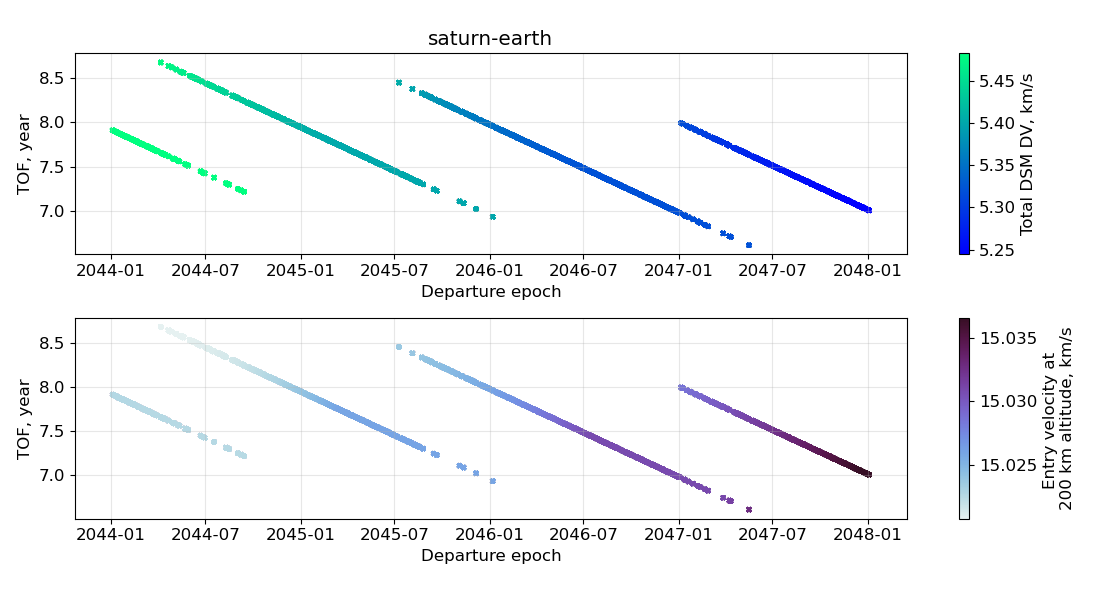

In [277]:
plt.rcParams["font.size"] = 12

fig, axs = plt.subplots(2,1,figsize=(11,6))

# first plot
im0 = axs[0].scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
                     c=porkchop_return['dsm_total']/1e3, cmap='winter', s=8, marker='x')
fig.colorbar(im0, label='Total DSM DV, km/s', ax=axs[0])
axs[0].set_title(seq_name)
axs[0].set(xlabel="Departure epoch", ylabel="TOF, year")
axs[0].grid(True, alpha=0.3)

# second plot
im1 = axs[1].scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
                     c=porkchop_return['entry_v']/1e3, cmap=cm.dense, s=8, marker='x')
fig.colorbar(im1, label='Entry velocity at \n200 km altitude, km/s', ax=axs[1])
#axs[1].set_title(seq_name)
axs[1].set(xlabel="Departure epoch", ylabel="TOF, year")
axs[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1.03, 0.98])
plt.show()

In [226]:
fig.savefig("./plots/interplanetar_inbound_windows_seq_"+seq_name+"_vinf_arr.png")

### Getting V-infinity at departure from Saturn fly-by?

In [24]:
def periapsis_velocity(rp, vinf, mu):
    energy = vinf**2/2
    vp = np.sqrt(2*(energy + mu/rp))
    return vp

In [25]:
vinf_depart_saturn = 2000  # m/s

In [26]:
flyby_altitude = 5000 # m
rp_leaving = pxp.R_SATURN + flyby_altitude

In [27]:
periapsis_velocity(rp_leaving, vinf_depart_saturn, pxp.MU_SATURN)

35538.11917956405

In [ ]:
#                     np.datetime64(
#                         datetime.datetime.strptime(
#                             pk.epoch(x[0]+tof_total).__str__()[0:11], 
#                             '%Y-%b-%d'
#                         ).strftime('%Y-%m-%d')
#                     )

### Plot of trajectory

```
        List[float], # DVs
        List[Any], # Lambert legs
        List[float], # T
        List[Tuple[List[float], List[float]]], # ballistic legs
        List[float], # epochs of ballistic legs
```

In [278]:
t0_earliest = np.datetime64(
    datetime.datetime.strptime("2046-09-01", '%Y-%m-%d')#.strftime('%Y-%m-%d')
)
t0_latest = np.datetime64(
    datetime.datetime.strptime("2046-11-05", '%Y-%m-%d')#.strftime('%Y-%m-%d')
)

in_arrival_window = []

for idx in range(len(porkchop_return['t0_matplotlib'])):
    if t0_earliest < porkchop_return['t0_matplotlib'][idx] < t0_latest:
        in_arrival_window.append(
            (porkchop_return["x"][idx], porkchop_return["f"][idx], porkchop_return["idx"][idx])
        )
len(in_arrival_window)

current_best = 1e5

for feasible in in_arrival_window:
    if feasible[1] < current_best:
        current_best = feasible[1]
        best_sol = feasible

In [279]:
#traj_comp = prob_test.get_trajectory_components(pareto_sols["min_dsm"])

In [280]:
pareto_sols["min_dsm"][0]

16803.153923206184

In [281]:
traj_comp[1]

((200274418765.79056, -1445501181789.6277, -13947276.340129852),
 (3828.739338852139, 2129.4779616465544, -5.825885297764452),
 169139469.0080175,
 1.32712440018e+20)

In [282]:
# baseline trajectory 
coord, dsm_info, traj_comp = pxp.coord_mga_1dsm(prob_test, best_sol[0], 86400)
prob_test.pretty(best_sol[0])

First Leg: 6, SUN, ECLIPJ2000 to 3, SUN, ECLIPJ2000
Departure: 2046-Nov-02 18:05:20.320541 (17107.753707413674 mjd2000) 
Duration: 2608.963212276033days
VINF: 2.748362508862968 km/sec
DSM after 679.3474084316885 days
DSM magnitude: 2570.98113056194m/s

Arrival at 3, SUN, ECLIPJ2000
Arrival epoch: 2053-Dec-24 17:12:21.861191 (19716.71691968971 mjd2000) 
Arrival Vinf: 10233.960194301631m/s
Total mission time: 7.142951984328633 years (2608.963212276033 days)


In [286]:
prob_test.fitness(best_sol[0])

[15553.303833726539]

In [291]:
prob_dsm_only = copy.deepcopy(prob_test)
prob_dsm_only.add_vinf_dep = False

In [292]:
prob_dsm_only.fitness(best_sol[0])

[15553.303833726539]

In [262]:
#np.save("baseline_inbound_interplantary", best_sol[0])
np.save("backup_inbound_interplantary", best_sol[0])

In [238]:
earth_coord = pxp.coord_planet(ssdict["earth"], t0, 6000)
#jup_coord   = pxp.coord_planet(ssdict["jupiter"], t0, 6000)
sat_coord   = pxp.coord_planet(ssdict["saturn"], t0, 6000)

In [245]:
coord.shape

(7, 2717)

<IPython.core.display.Javascript object>


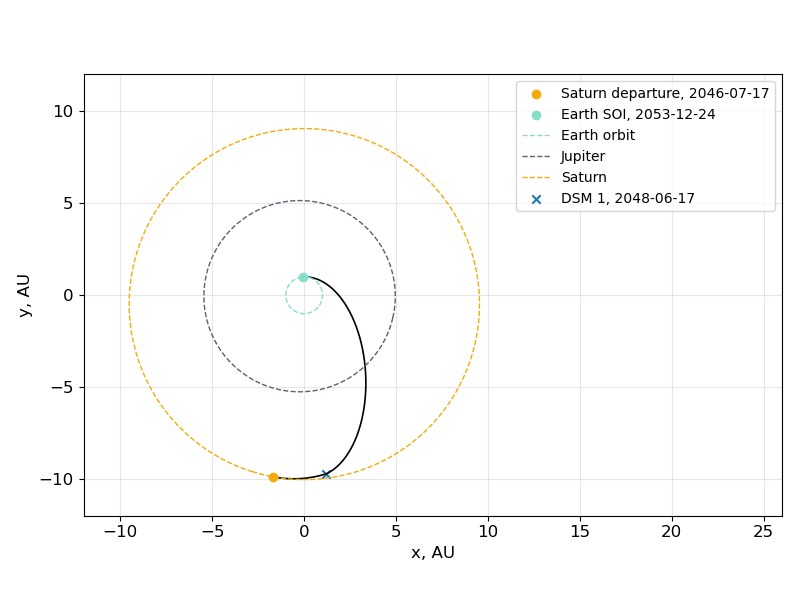

In [248]:
earth_coord = pxp.coord_planet(ssdict["earth"], t0, 6000)
jup_coord   = pxp.coord_planet(ssdict["jupiter"], t0, 6000)
sat_coord   = pxp.coord_planet(ssdict["saturn"], t0, 6000)

plt.rcParams["font.size"] = 12

fig, ax = plt.subplots(1,1,figsize=(8,6))

# trajectory
ax.plot(coord[1,:]/pk.AU, coord[2,:]/pk.AU, c="black", lw=1.2)

ax.scatter(coord[1,0]/pk.AU, coord[2,0]/pk.AU, c="#F4AB07", zorder=3,
          label="Saturn departure, 2046-07-17")
ax.scatter(coord[1,-1]/pk.AU, coord[2,-1]/pk.AU, c="#86DDC8", zorder=3,
          label="Earth SOI, 2053-12-24")

# planets
ax.plot(earth_coord[0,:]/pk.AU, earth_coord[1,:]/pk.AU, c="#86DDC8", lw=1.0, ls="--", label="Earth orbit")
ax.plot(jup_coord[0,:]/pk.AU, jup_coord[1,:]/pk.AU, c="#605D74", lw=1.0, ls="--", label="Jupiter")
ax.plot(sat_coord[0,:]/pk.AU, sat_coord[1,:]/pk.AU, c="#F4AB07", lw=1.0, ls="--", label="Saturn")

# DSMs
# for i,dsm in enumerate(dsm_info):
#     ax.scatter(dsm[0][0]/pk.AU, dsm[0][1]/pk.AU, marker="x", label=f"DSM {i+1}")
ax.scatter(dsm_info[0][0][0]/pk.AU, dsm_info[0][0][1]/pk.AU, 
           marker="x", label=f"DSM {1}, 2048-06-17")


ax.set(xlabel="x, AU", ylabel="y, AU")
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim([-12,26])
ax.set_ylim([-12,12])
ax.legend()

plt.tight_layout(rect=[0, -0.0, 1, 1.0])
plt.show()

In [249]:
fig.savefig("./plots/nominal_inbound_interplanetary_traj.png")